# Extracting features from SONATA Network simulations

This notebook shows how to extract features of a group of cells from a SONATA network with the help of [BlueCellulLab](https://github.com/BlueBrain/BlueCelluLab/). For more details about the simulation, please refer to the Bluecellulab [SONATA Network example](https://github.com/BlueBrain/BlueCelluLab/blob/main/examples/2-sonata-network/sonata-network.ipynb).

**Note**: The compiled mechanisms need to be provided before importing bluecellulab.

In [ ]:
!nrnivmodl ../mechanisms

In [ ]:
import json
from pathlib import Path

from matplotlib import pyplot as plt

from bluecellulab import SSim
import efel

In this example, a small sub-circuit has been extracted from the [sscx circuit](https://zenodo.org/records/8026353). This sub-circuit specifically consists of a random selection of cells exhibiting delayed stuttering (dSTUT) etype. The simulation_config specifies the types of input stimuli to be applied to the cells. In this case, we have selected a 'relative_linear' stimulus of 70 ms and set the stimulus current at a level equivalent to 100 percent of the cell's threshold current.

In [3]:
simulation_config = Path("./") / "simulation_config.json"
with open(simulation_config) as f:
    simulation_config_dict = json.load(f)
print(json.dumps(simulation_config_dict, indent=4))

{
    "manifest": {
        "$OUTPUT_DIR": "."
    },
    "run": {
        "tstop": 100.0,
        "dt": 0.025,
        "random_seed": 1
    },
    "conditions": {
        "v_init": -65
    },
    "target_simulator": "NEURON",
    "network": "./O1/circuit_config.json",
    "node_set": "dSTUT_mini",
    "output": {
        "output_dir": "$OUTPUT_DIR/output_sonata",
        "spikes_file": "out.h5",
        "spikes_sort_order": "by_time"
    },
    "inputs": {
        "continuous_linear": {
            "input_type": "current_clamp",
            "module": "relative_linear",
            "delay": 20.0,
            "duration": 70.0,
            "percent_start": 100,
            "node_set": "dSTUT_mini"
        }
    },
    "reports": {
        "soma": {
            "cells": "dSTUT_mini",
            "variable_name": "v",
            "type": "compartment",
            "dt": 1.0,
            "start_time": 0.0,
            "end_time": 20.0,
            "sections": "soma",
            "compartmen

We use BlueCellulab for simulating smaller scare circuits, in contrast to the larger-scale simulations conducted with Neurodamus.

In [4]:
simulation_config = Path("./") / "simulation_config.json"
with open(simulation_config) as f:
    simulation_config_dict = json.load(f)
sim = SSim(simulation_config)

In [5]:
from bluepysnap import Simulation as snap_sim
snap_access = snap_sim(simulation_config)
import pandas as pd
from bluepysnap import Simulation as snap_sim
all_nodes = pd.concat([x[1] for x in snap_access.circuit.nodes.get()])
dstut_cells = all_nodes[all_nodes["etype"] == "dSTUT"].index.to_list()

In [6]:
sim.instantiate_gids(dstut_cells, add_stimuli=True)
t_stop = 100.0
sim.run(t_stop)

The plot displays the voltage traces simulated for each cell in our circuit.

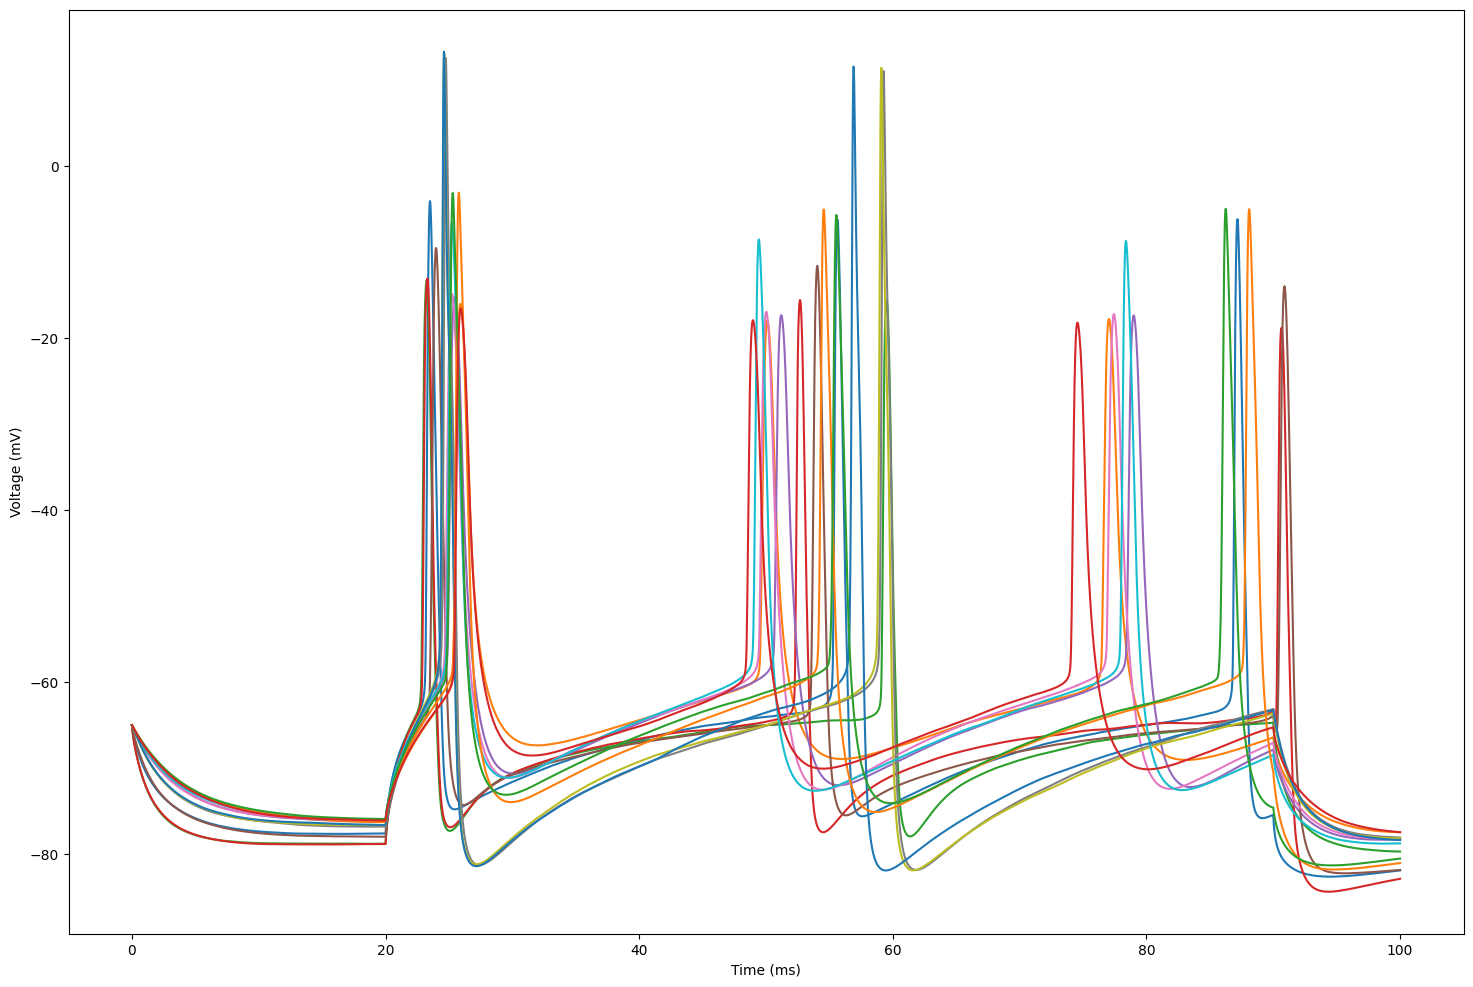

In [7]:
# Define the figure size
plt.figure(figsize=(18, 12))
for cell_id in sim.cells:
    # Get the voltage trace
    time = sim.get_time_trace()
    voltage = sim.get_voltage_trace(cell_id)
    plt.plot(time, voltage, label=cell_id)
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")


We're ready to extract data from the simulated traces obtained using BlueCellulab. Next, we'll build the data structure for eFEL processing.

In [8]:
traces = []
for cell_id in sim.cells:
    voltage = sim.get_voltage_trace(cell_id)
    #print(voltage)
    trace = {}
    trace['T'] = time
    trace['V'] = voltage
    trace['stim_start'] = [20]
    trace['stim_end'] = [90]
    traces.append(trace)

We choose the specific features of interest

In [9]:
features = ['AP_amplitude', 'voltage_base', 'Spikecount']

Finally, we perform the feature extraction

In [10]:
traces_results = efel.getFeatureValues(traces, features)

In [11]:
for trace_result in traces_results:
    for feature_name, feature_values in trace_result.items():
        print("%s  %s" % \
            (feature_name, ', '.join([str(x) for x in feature_values])))

AP_amplitude  57.70850268793035, 53.80192555074319, 54.88610970056221
voltage_base  -77.6044286819145
Spikecount  3
AP_amplitude  43.05751390566441, 39.964318545907275, 40.72798983612387
voltage_base  -76.26183621755374
Spikecount  3
AP_amplitude  48.899413895458316, 46.81749279646703
voltage_base  -78.7916804618937
Spikecount  2
AP_amplitude  49.09718706650314, 46.73497011970878
voltage_base  -78.82550905725957
Spikecount  3
AP_amplitude  42.71138025227143, 39.250799678218954, 39.18162705782062
voltage_base  -76.0909397047961
Spikecount  3
AP_amplitude  53.3944262446857, 50.44903882718782
voltage_base  -77.96145298100336
Spikecount  3
AP_amplitude  43.21550575179654, 40.109869870982294, 39.863023182538505
voltage_base  -76.04136091850545
Spikecount  3
AP_amplitude  67.53085755516375, 68.26334072383608
voltage_base  -76.7937027649595
Spikecount  2
AP_amplitude  69.87240740434514, 68.01923333751068
voltage_base  -76.6241289401677
Spikecount  2
AP_amplitude  51.42170708797177, 48.5748482